In [1]:
import os
import random
import time
import torch
import torch.nn as nn
import numpy as np

import tntorch as tn

In [9]:
def tt_multiply_custom(tt: tn.Tensor, vector : torch.Tensor, shapes, in_dims, ranks):
    """
    tensor: bs*768
    in_dims = [32, 24]
    """
    bs = vector.shape[0]
    seq_len = vector.shape[1]
    print (bs, seq_len)
    result = vector.reshape(bs*seq_len, in_dims[0], -1)
    core = tt.cores[0].reshape(in_dims[0], tt.cores[0].shape[2])
    print (result.shape, core.shape)
    result = torch.einsum('bid,ir->bdr', result, core)
    print (result.shape)
    for i in range(1, len(tt.cores)):
        if (i < len(in_dims)):
            result = result.reshape(-1, in_dims[i], tt.cores[i].shape[0])
            core = tt.cores[i].reshape(tt.cores[i].shape[0], in_dims[i], -1, tt.cores[i].shape[2])
            print (result.shape, core.shape)
            result = torch.einsum('bdr,rdac->bac', result, core)
            print (result.shape)
        else:
            result = result.reshape(bs, -1, tt.cores[i].shape[0])
            core = tt.cores[i].reshape(tt.cores[i].shape[0], -1, tt.cores[i].shape[2])
            print (result.shape, core.shape)
            result = torch.einsum('bdr,rga->bdga', result, core)
            print (result.shape)
    return result.reshape(bs, seq_len, -1)
            
    #while (i < len(in_dims)):
        

In [10]:
for elem in tt.cores:
    print (type(elem))
    print (elem.shape)

<class 'torch.Tensor'>
torch.Size([1, 32, 32])
<class 'torch.Tensor'>
torch.Size([32, 48, 480])
<class 'torch.Tensor'>
torch.Size([480, 48, 32])
<class 'torch.Tensor'>
torch.Size([32, 32, 1])


In [11]:
v = torch.rand(256, 142, 768)
m = torch.rand(768, 3072)
m_new = m.reshape((32, 48, 48, 32))
print (torch.allclose(m, m_new.reshape(768, 3072), atol=1e-05))
tt = tn.Tensor(m_new, ranks_tt=[380, 480, 380])

True


In [14]:
(v @ m).shape

torch.Size([256, 142, 3072])

In [13]:
res = tt_multiply_custom(tt, v, (32, 48, 48, 32), [32, 24], [1, 3, 4, 5, 1])

256 142
torch.Size([36352, 32, 24]) torch.Size([32, 32])
torch.Size([36352, 24, 32])
torch.Size([36352, 24, 32]) torch.Size([32, 24, 2, 480])
torch.Size([36352, 2, 480])
torch.Size([256, 284, 480]) torch.Size([480, 48, 32])
torch.Size([256, 284, 48, 32])
torch.Size([256, 13632, 32]) torch.Size([32, 32, 1])
torch.Size([256, 13632, 32, 1])


In [15]:
res[:5, 2, 10]

tensor([185.2893, 189.9231, 192.0984, 187.3029, 187.7662])

In [8]:
a = tt.torch().reshape(768, 3072)
print (a.shape)
print ((v @ a).shape)
print (res.shape)
print ((v @ a)[:5, 2, 10])

torch.Size([768, 3072])
torch.Size([256, 142, 3072])
torch.Size([256, 142, 3072])
tensor([190.8096, 190.1509, 193.0630, 190.5253, 207.3197])


In [9]:
torch.norm((v @ a)- res)/torch.norm(res)

tensor(1.6245e-07)

In [111]:
print (torch.allclose(res, (v @ a)))

True


In [30]:
v = torch.rand(256, 142, 768)
m = torch.rand(3072, 768)
m_new = m.reshape((32, 48, 48, 32))
print (torch.allclose(m, m_new.reshape(3072, 768), atol=1e-05))
tt = tn.Tensor(m_new, ranks_tt=[3, 4, 3])

True


In [31]:
for elem in tt.cores:
    print (type(elem))
    print (elem.shape)

<class 'torch.Tensor'>
torch.Size([1, 32, 3])
<class 'torch.Tensor'>
torch.Size([3, 48, 4])
<class 'torch.Tensor'>
torch.Size([4, 48, 3])
<class 'torch.Tensor'>
torch.Size([3, 32, 1])


In [32]:
res = tt_multiply_custom(tt, v, (32, 48, 48, 32), [32, 48, 2], [1, 3, 4, 3, 1])

256 142
torch.Size([36352, 32, 24]) torch.Size([32, 3])
torch.Size([36352, 24, 3])
torch.Size([18176, 48, 3]) torch.Size([3, 48, 1, 4])
torch.Size([18176, 1, 4])
torch.Size([9088, 2, 4]) torch.Size([4, 2, 24, 3])
torch.Size([9088, 24, 3])
torch.Size([256, 852, 3]) torch.Size([3, 32, 1])
torch.Size([256, 852, 32, 1])


In [115]:
a = tt.torch().reshape(3072, 768)
print (a.shape)
print ((v @ a)[:5, 10])

torch.Size([3072, 768])
tensor([780.9492, 773.5886, 772.0028, 771.8756, 772.8912])


In [116]:
res[:5, 10]

tensor([780.9583, 773.3998, 771.8484, 771.7330, 772.8489])

In [119]:
print (torch.allclose(res, (v @ a)))

False


In [120]:
torch.norm((v @ a)- res)/torch.norm(res)

tensor(0.0002)

In [ ]:
torch.allclose(m, m_new.reshape(3072, 768), atol=1e-05)

## regular tt

In [121]:
v = torch.rand(30, 768)
m = torch.rand(768, 3072)
m_new = m.reshape((32, 24, 64, 48))
print (torch.allclose(m, m_new.reshape(768, 3072), atol=1e-05))
tt = tn.Tensor(m_new, ranks_tt=[3, 4, 5])

True


In [122]:
res = tt_multiply_custom(tt, v, (32, 24, 64, 48), [32, 24], [1, 3, 4, 5, 1])

30
torch.Size([30, 32, 24]) torch.Size([32, 3])
torch.Size([30, 24, 3])
torch.Size([30, 24, 3]) torch.Size([3, 24, 1, 4])
torch.Size([30, 1, 4])
torch.Size([30, 1, 4]) torch.Size([4, 64, 5])
torch.Size([30, 1, 64, 5])
torch.Size([30, 64, 5]) torch.Size([5, 48, 1])
torch.Size([30, 64, 48, 1])


In [124]:
a = tt.torch().reshape(768, 3072)
print (a.shape)
print ((v @ a)[:5, 10])

torch.Size([768, 3072])
tensor([187.1352, 195.8420, 189.3099, 190.3286, 191.1834])


In [123]:
res[:5, 10]

tensor([187.1352, 195.8420, 189.3099, 190.3287, 191.1834])

In [125]:
torch.allclose((v @ a), res)

True

**singular values**

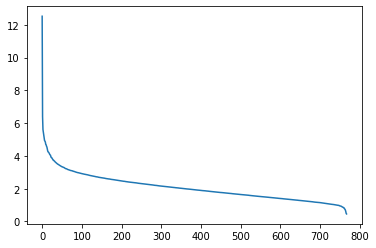

In [14]:
plt.plot(s)
plt.show()

In [6]:
{6:(0, 2, 4, 1, 3, 5), 8:(0, 2, 4, 6, 1, 3, 5, 7), 10:(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}

{6: (0, 2, 4, 1, 3, 5),
 8: (0, 2, 4, 6, 1, 3, 5, 7),
 10: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}

In [7]:
a = colbert.bert.encoder.layer[4].intermediate.dense(input_)

NameError: name 'input_' is not defined

In [8]:
b = fc_w_new(input_)

NameError: name 'input_' is not defined

In [ ]:
from tensorly.tt_matrix import TTMatrix

perms = {6:(0, 2, 4, 1, 3, 5), 8:(0, 2, 4, 6, 1, 3, 5, 7), 10:(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}

for rank in [ 20, 30, 40, 50]:
    m = colbert.bert.encoder.layer[4].intermediate.dense
    input_ = torch.randn(batch_size, in_)
    m_ttm = FactorizationTTMLinear(in_, out_, rank=rank, max_core_dim_product =rank)
    m_ttm.fill_with_pretrained_matrix(fc_w)
    restored_weight = TTMatrix([elem.data for elem in m_ttm.ttm.tt.cores]).to_tensor()
    print (restored_weight.shape)
    restored_weight = restored_weight.permute(perms[(len(restored_weight.shape))])
    print (restored_weight.shape)
    print (torch.norm(fc_w_new.weight - restored_weight.reshape(fc_w_new.weight.shape))/torch.norm(fc_w_new.weight))
    print (restored_weight.shape)
    c = m_ttm(input_)
    print (torch.norm(a-c)/torch.norm(a))
    print ("\n\n\n")

In [46]:
torch.norm(a-c)

tensor(771.9188, grad_fn=<CopyBackwards>)

In [47]:
torch.norm(a-b)

tensor(0., grad_fn=<CopyBackwards>)

In [4]:
factors = tensor_train_matrix(B, rank = [1, 60, 90, 1])

NameError: name 'tensor_train_matrix' is not defined

In [20]:
for elem in factors.factors:
    print (elem.shape)

torch.Size([1, 8, 16, 60])
torch.Size([60, 12, 12, 90])
torch.Size([90, 8, 16, 1])


In [454]:
new_B = factors.to_tensor()
new_B.shape

torch.Size([8, 16, 12, 8, 12, 16])

In [455]:
B.shape

torch.Size([8, 16, 12, 8, 12, 16])

In [456]:
np.linalg.norm(new_B - B)/np.linalg.norm(B)

0.70110387

In [457]:
for elem in factors:
    print (elem.shape)

torch.Size([1, 8, 8, 60])
torch.Size([60, 16, 12, 90])
torch.Size([90, 12, 16, 1])


In [16]:
fc_w.shape[1],fc_w.shape[0]

(768, 3072)

In [1]:
from src.ttm_linear.ttm_linear.ttm_linear import FactorizationTTMLinear

In [14]:
B.shape

torch.Size([32, 48, 48, 32])

In [ ]:
errs2 = []
ranks2 = []
c_rates2 = []

import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')


B = fc_w
B = B.reshape((32, 48, 48, 32))




err = 10.0
rank1 = 5
rank2 = 5
step = 10
compression_rate = 0.0
while (compression_rate < 0.7):
    factors = tensor_train(B, rank = [1, rank1, rank2, rank1, 1])
    new_B = factors.to_tensor()
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs2.append(err)
    ranks2.append(rank1)
    c_rates2.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

In [53]:
errs3 = []
ranks3 = []
c_rates3 = []

import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')


B = fc_w
B = B.reshape(128, 144, 128)




err = 10.0
rank1 = 5
rank2 = 5
step = 10
compression_rate = 0.0
while (compression_rate < 0.7):
    factors = tensor_train(B, rank = [1, rank1, rank2, 1])
    new_B = factors.to_tensor()
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs3.append(err)
    ranks3.append(rank1)
    c_rates3.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

[torch.Size([1, 128, 5]), torch.Size([5, 144, 5]), torch.Size([5, 128, 1])]
err  0.9830911 compression_rate  0.002068413628472222 rank  5 5
[torch.Size([1, 128, 5]), torch.Size([5, 144, 15]), torch.Size([15, 128, 1])]
err  0.97657156 compression_rate  0.005662706163194444 rank  5 15
[torch.Size([1, 128, 15]), torch.Size([15, 144, 15]), torch.Size([15, 128, 1])]
err  0.9700918 compression_rate  0.015360514322916666 rank  15 15
[torch.Size([1, 128, 15]), torch.Size([15, 144, 25]), torch.Size([25, 128, 1])]
err  0.96239424 compression_rate  0.025058322482638888 rank  15 25
[torch.Size([1, 128, 25]), torch.Size([25, 144, 25]), torch.Size([25, 128, 1])]
err  0.9518059 compression_rate  0.04085964626736111 rank  25 25
[torch.Size([1, 128, 25]), torch.Size([25, 144, 35]), torch.Size([35, 128, 1])]
err  0.94061637 compression_rate  0.056660970052083336 rank  25 35
[torch.Size([1, 128, 35]), torch.Size([35, 144, 35]), torch.Size([35, 128, 1])]
err  0.92628205 compression_rate  0.078565809461805

In [1]:
import matplotlib.pyplot as plt
  

# plot lines
plt.plot(c_rates, errs, label = "SVD")
plt.plot(c_rates3, errs3,  label = "TT 3 cores, 128*144*128 ")
plt.plot(c_rates3, errs3,  label = "TT 4 cores, 32*48*48*32 ")
plt.plot(c_rates1, errs1,  label = "TT 6 cores, 8*12*16*16*12*8")
#plt.plot(errs1_m, c_rates1_m, label = "TTM (permute + reshape)")
plt.ylabel('errors')
plt.xlabel('compression rate')
plt.legend()
plt.savefig("TT + SVD")
plt.show()

NameError: name 'c_rates' is not defined

In [28]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

errs1 = []
ranks1 = []
c_rates1 = []

B = fc_w
B = B.reshape(8, 12, 16, 16, 12, 8)




err = 10.0
rank1 = 5
rank2 = 5
step = 10
compression_rate = 0.0
while (compression_rate < 0.7):
    factors = tensor_train(B, rank = [1, rank1, rank2, rank2, rank2, rank1, 1])
    new_B = factors.to_tensor()
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs1.append(err)
    ranks1.append(rank1)
    c_rates1.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

[torch.Size([1, 8, 8]), torch.Size([8, 12, 96]), torch.Size([96, 16, 335]), torch.Size([335, 16, 96]), torch.Size([96, 12, 8]), torch.Size([8, 8, 1])]
err  0.5942937 compression_rate  0.4440646701388889 rank  335 335
[torch.Size([1, 8, 8]), torch.Size([8, 12, 96]), torch.Size([96, 16, 345]), torch.Size([345, 16, 96]), torch.Size([96, 12, 8]), torch.Size([8, 8, 1])]
err  0.5857147 compression_rate  0.4570855034722222 rank  335 345
[torch.Size([1, 8, 8]), torch.Size([8, 12, 96]), torch.Size([96, 16, 345]), torch.Size([345, 16, 96]), torch.Size([96, 12, 8]), torch.Size([8, 8, 1])]
err  0.5857147 compression_rate  0.4570855034722222 rank  345 345
[torch.Size([1, 8, 8]), torch.Size([8, 12, 96]), torch.Size([96, 16, 355]), torch.Size([355, 16, 96]), torch.Size([96, 12, 8]), torch.Size([8, 8, 1])]
err  0.5772192 compression_rate  0.4701063368055556 rank  345 355
[torch.Size([1, 8, 8]), torch.Size([8, 12, 96]), torch.Size([96, 16, 355]), torch.Size([355, 16, 96]), torch.Size([96, 12, 8]), torc

In [ ]:
B = fc_w
B = B.reshape((32, 48, 48, 32))

In [5]:
np.prod(fc_w.shape)

2359296

In [147]:
D_rest = tl.tt_tensor.tt_to_tensor(factors)
err = np.linalg.norm(D_rest - D)/np.linalg.norm(D)
err

0.81661785